In [210]:
import pandas as pd
import datetime
import yfinance as yf
import seaborn as sns
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [211]:
df = yf.download ("AXP", 
                   start = "2020-03-30", 
                   end = "2023-04-02", 
                   progress = False, 
                   auto_adjust = True)["Close"]
df

Date
2020-03-30     86.542305
2020-03-31     82.074760
2020-04-01     74.625610
2020-04-02     73.902596
2020-04-03     70.952660
                 ...    
2023-03-27    163.119995
2023-03-28    159.210007
2023-03-29    163.589996
2023-03-30    162.410004
2023-03-31    164.949997
Name: Close, Length: 758, dtype: float64

In [212]:
# yahoo finance includes time in date-time for time series, must reset index to remove time for excel output
df1 = df.reset_index() # move date and time to axis 1 index 0
date = df1['Date'].dt.date # remove time stamp
ex_dt = df1.iloc[:,1:] # create new date only index column
axp = ex_dt.set_index(date) # set date column

<Axes: title={'center': 'AXP Daily Price Movement'}, xlabel='Date'>

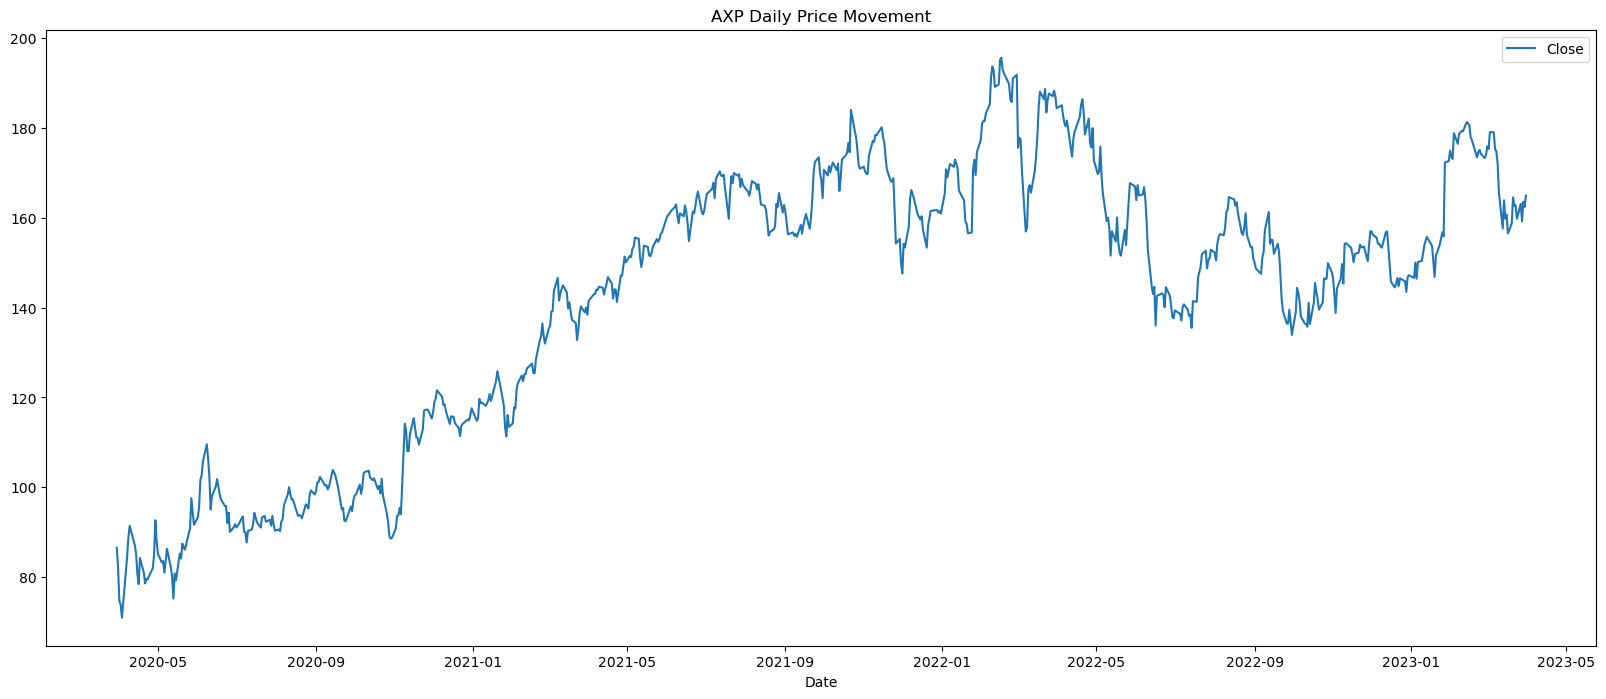

In [213]:
axp.plot(title = "AXP Daily Price Movement", figsize=(20, 8))

In [214]:
axp.reset_index(inplace = True)

In [215]:
axp.columns = ["ds", "y"]
axp

,ds,y
0,2020-03-30,86.542305
1,2020-03-31,82.074760
2,2020-04-01,74.625610
3,2020-04-02,73.902596
4,2020-04-03,70.952660
...,...,...
753,2023-03-27,163.119995
754,2023-03-28,159.210007
755,2023-03-29,163.589996
756,2023-03-30,162.410004


In [216]:
# split the data into training and test sets
train_indices = axp["ds"].astype(str) < "2023-01-30"
df_train = axp.loc[train_indices].dropna()
df_test = (
 axp
 .loc[~train_indices]
 .reset_index(drop=True)
)

In [217]:
# create the Prophet model and fit to the training data
prophet = Prophet(changepoint_range=0.9)
prophet.add_country_holidays(country_name="US")
prophet.add_seasonality(
 name="monthly", period=30.5, fourier_order=5
)
prophet.fit(df_train)

02:30:22 - cmdstanpy - INFO - Chain [1] start processing
02:30:23 - cmdstanpy - INFO - Chain [1] done processing


In [218]:
future_date = pd.to_datetime("2023-05-01")
df_future = prophet.make_future_dataframe(periods=1, freq='D')
df_future.loc[len(df_future)-1, 'ds'] = future_date


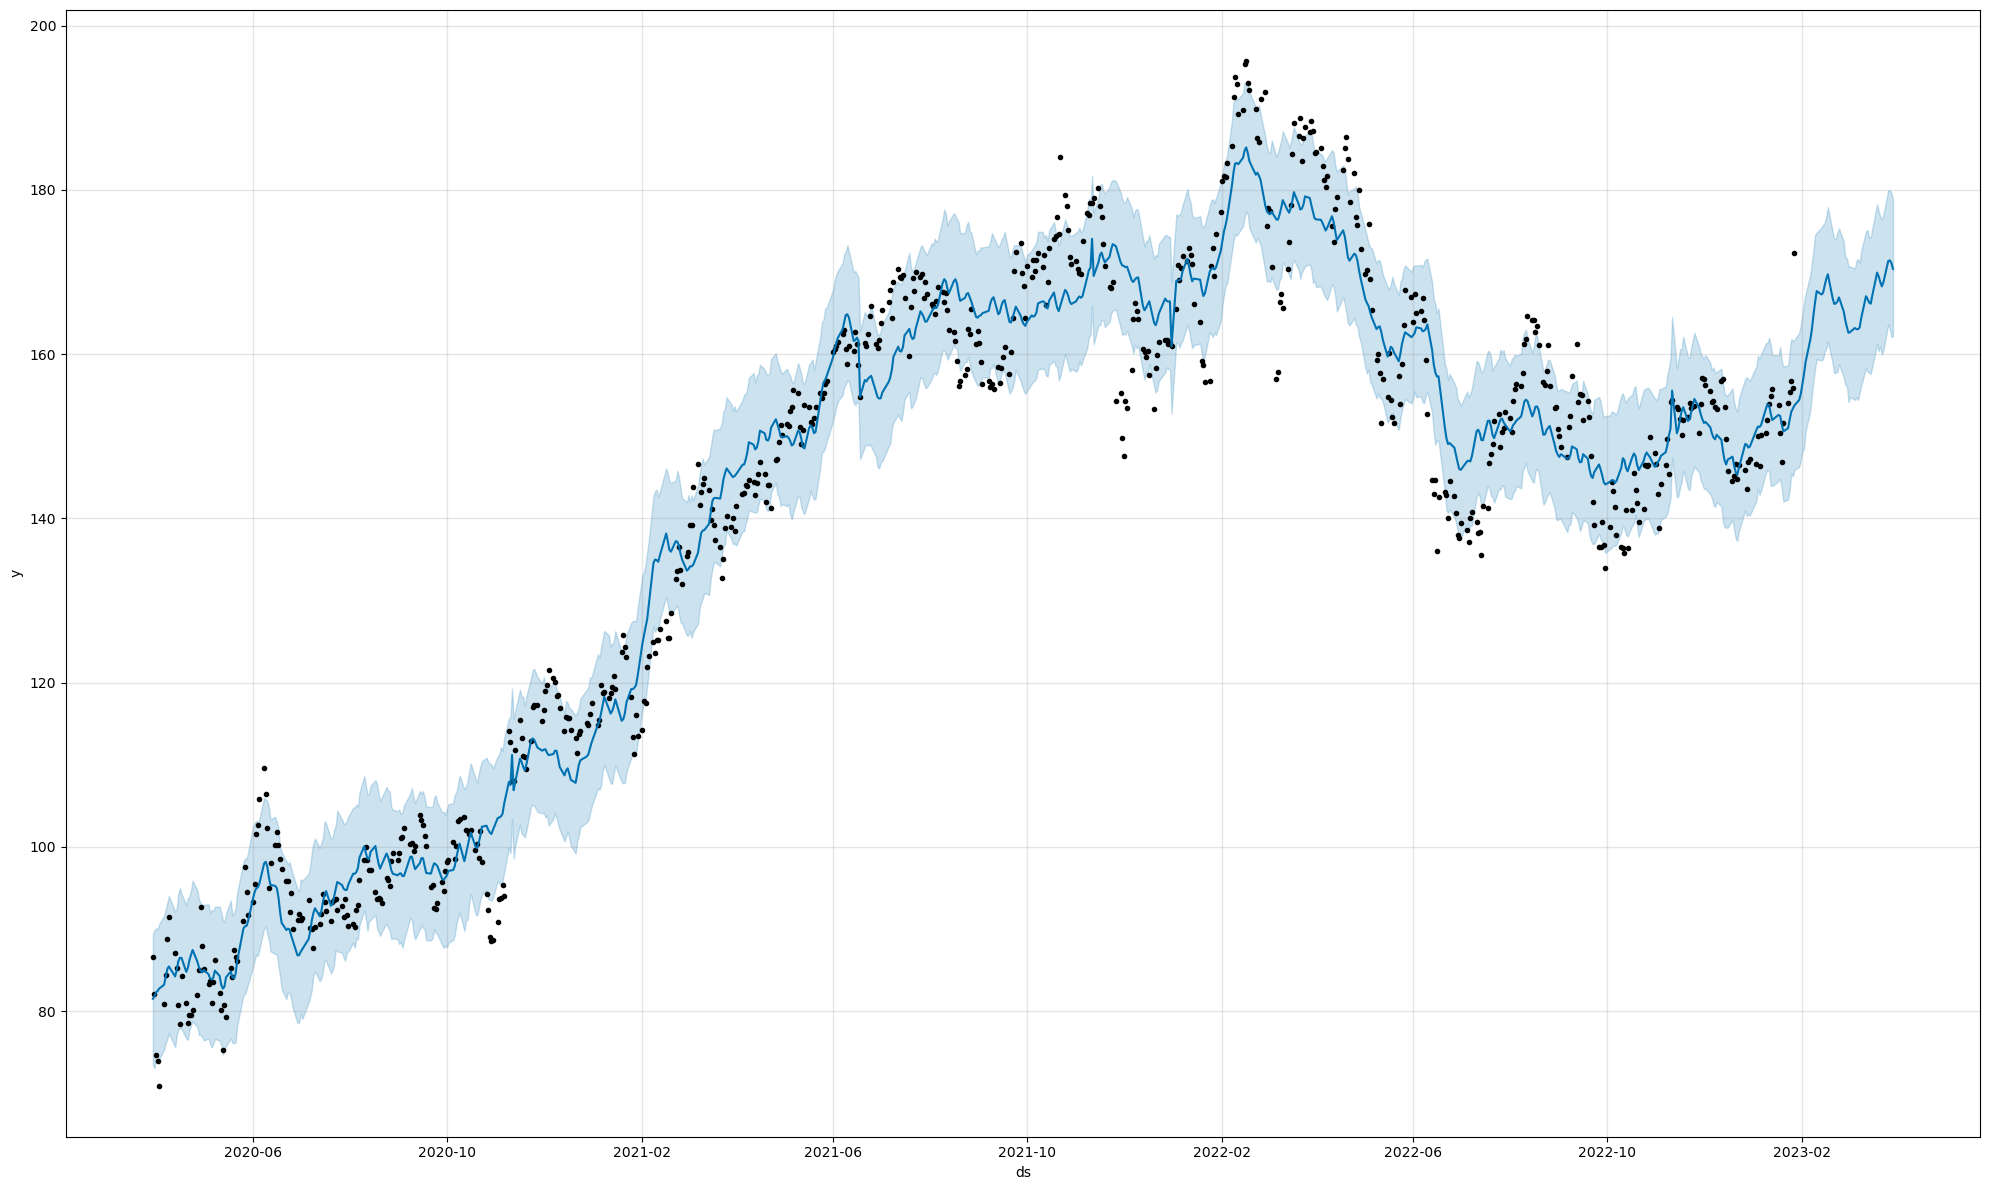

In [219]:
# use the model to make predictions for the specified future date
df_future = prophet.make_future_dataframe(
    periods=len(df_test), freq="B"
)
df_pred = prophet.predict(df_future)
fig = prophet.plot(df_pred, figsize=(20, 12))


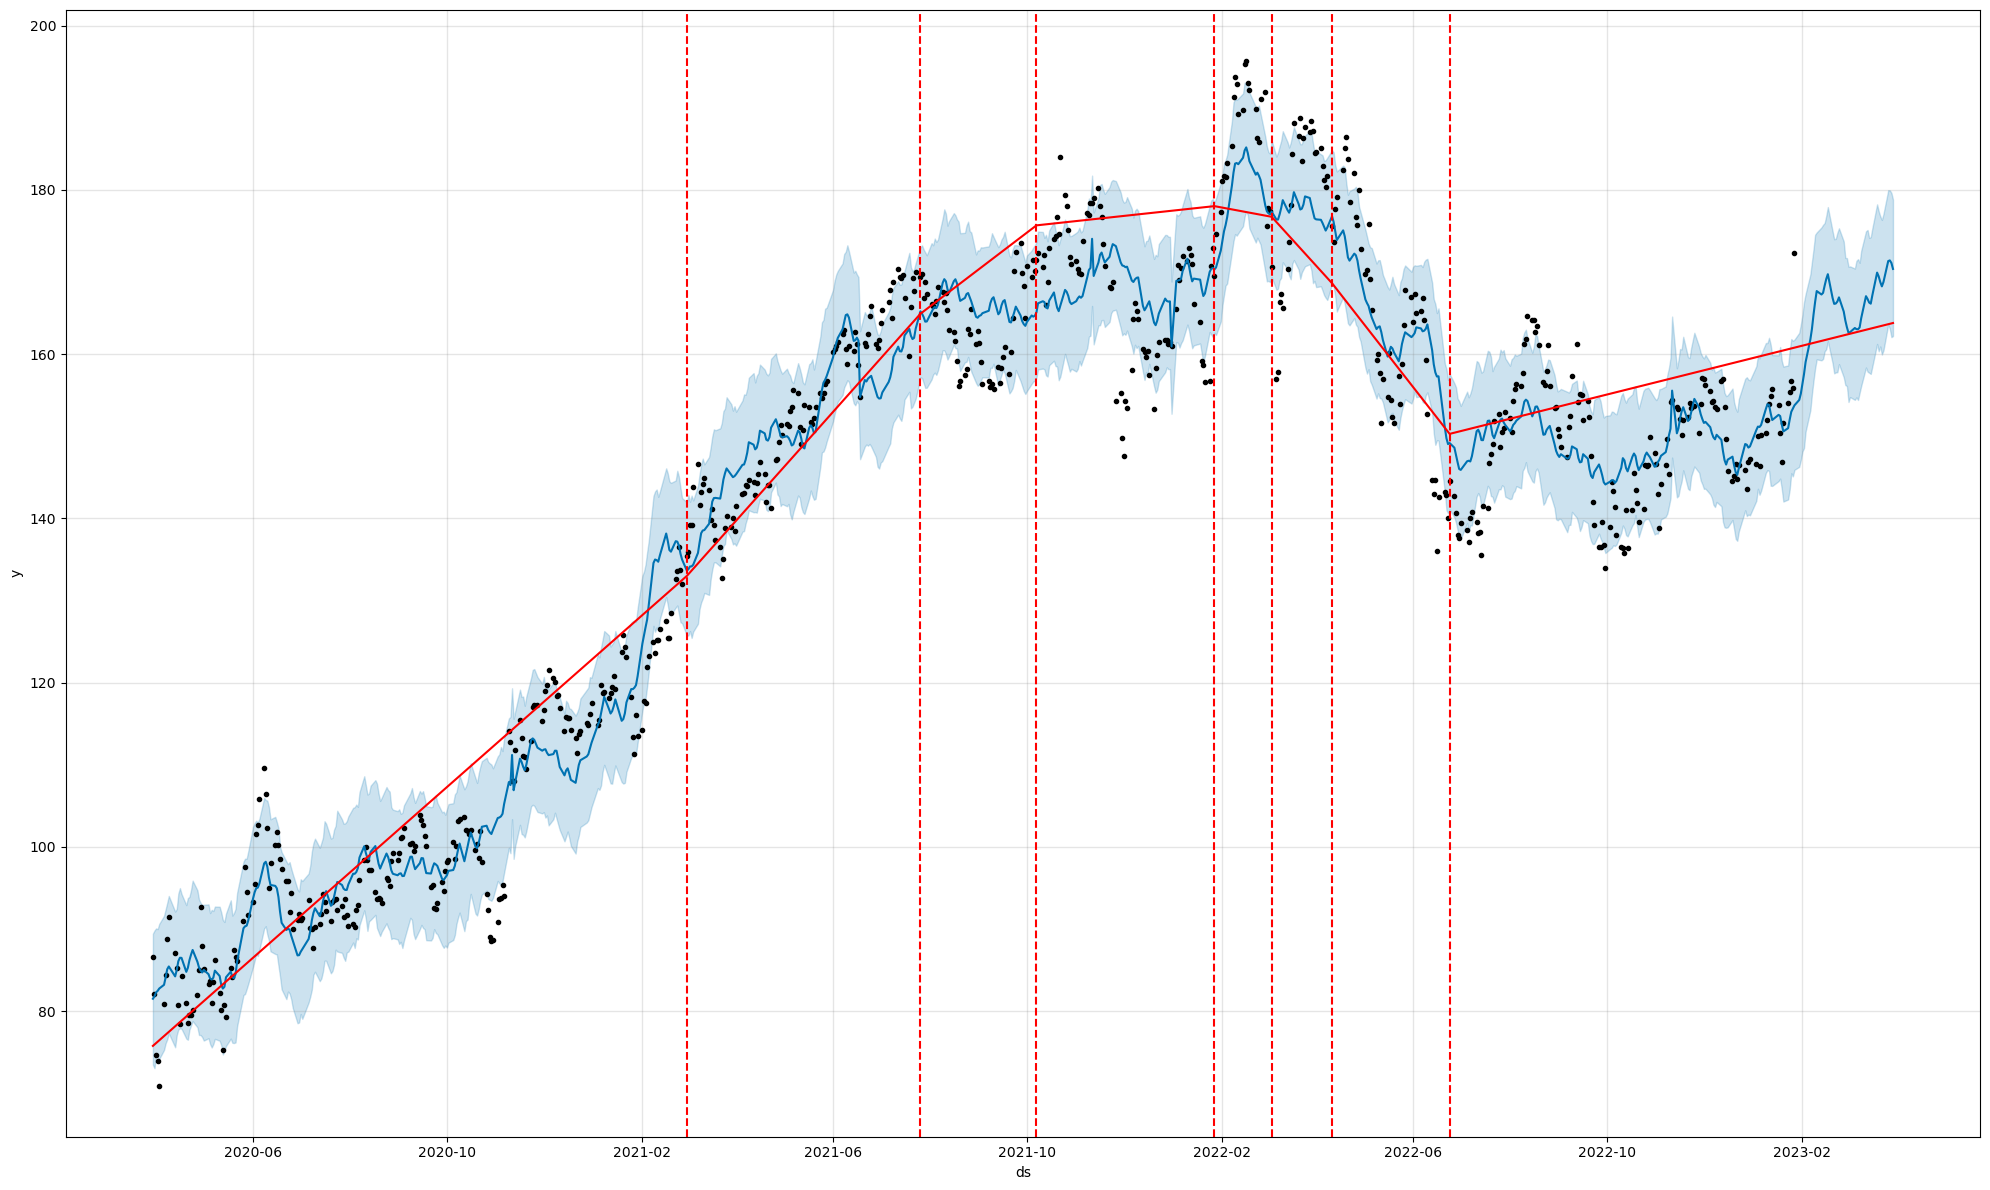

In [220]:
fig = prophet.plot(df_pred, figsize=(20, 12))
a = add_changepoints_to_plot(
    fig.gca(), prophet, df_pred
)

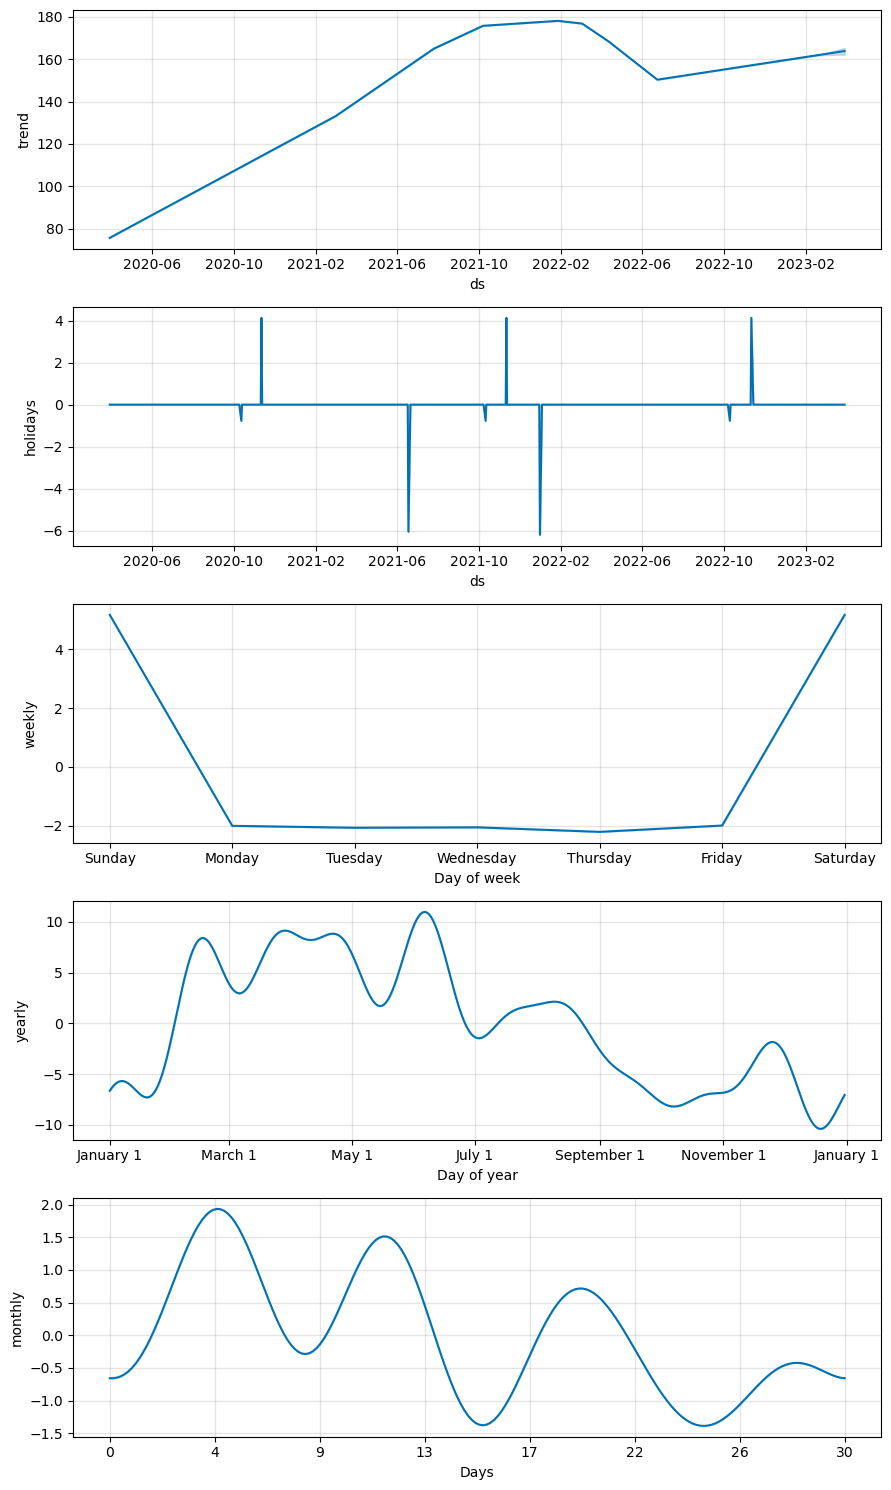

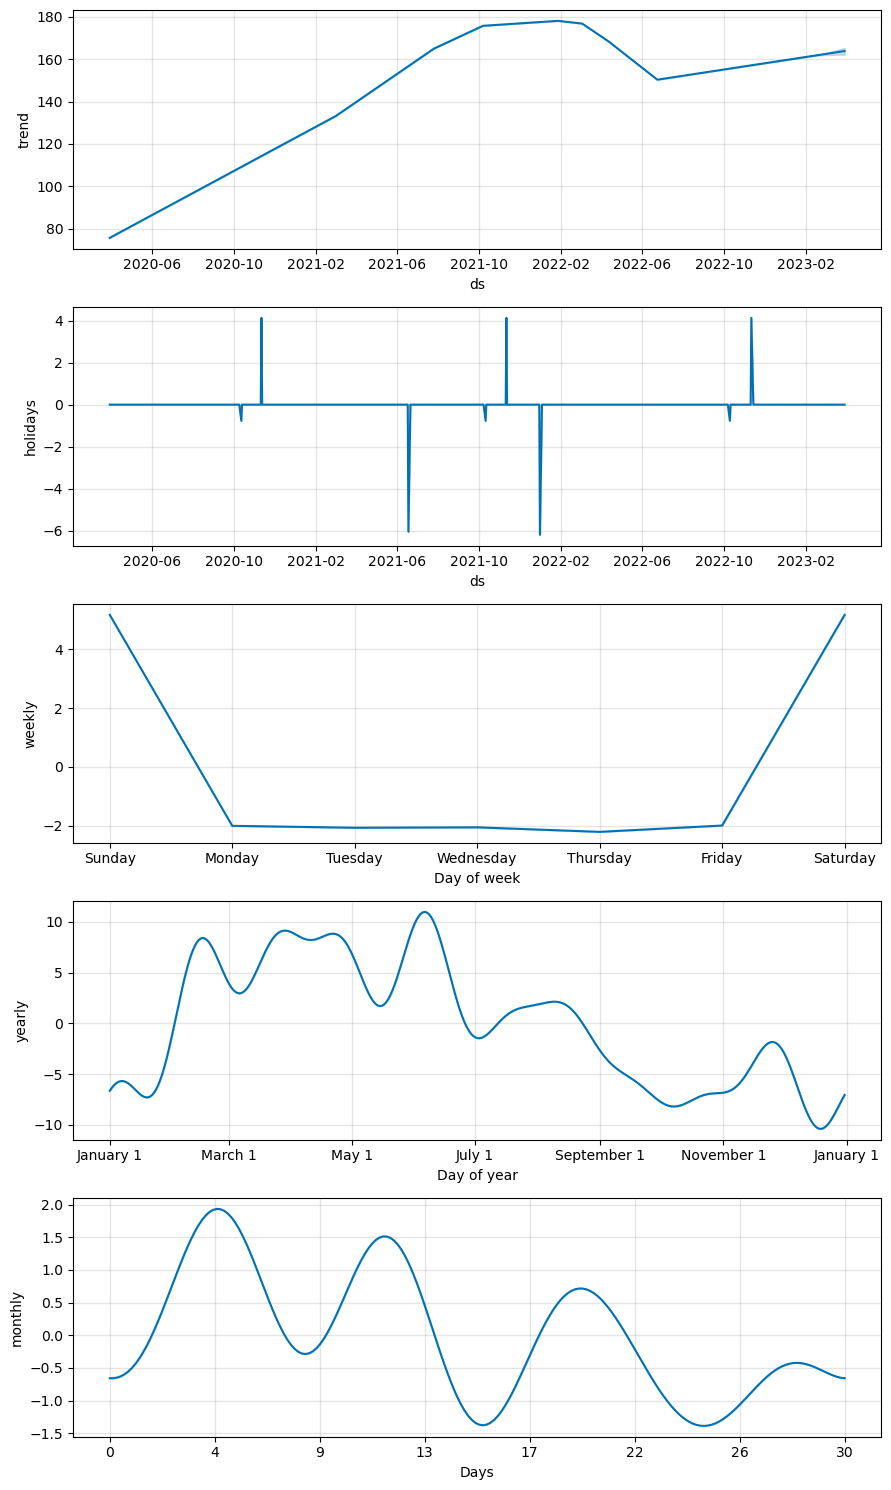

In [221]:
prophet.plot_components(df_pred)

In [223]:
SELECTED_COLS = [
"ds", "yhat", "yhat_lower", "yhat_upper"
]
df_pred = (
    df_pred
    .loc[:, SELECTED_COLS]
    .reset_index(drop=True)
)

df_pred["ds"] = pd.to_datetime(df_pred["ds"])
df_test = df_test.set_index("ds")
df_pred = df_pred.set_index("ds")
df_test = pd.concat([df_test, df_pred], axis=1, join="outer")



C:\Users\garci\AppData\Local\Temp\ipykernel_13280\188028027.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_test = pd.concat([df_test, df_pred], axis=1, join="outer")


[Text(0.5, 1.0, 'Gold Price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Gold Price ($)')]

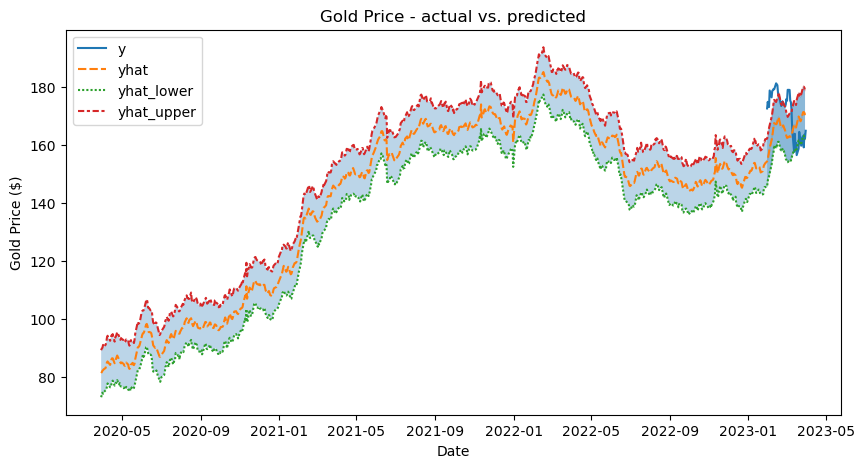

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
PLOT_COLS = ["y", "yhat", "yhat_lower", "yhat_upper"]
ax = sns.lineplot(data=df_test[PLOT_COLS])
ax.fill_between(
    df_test.index,
    df_test["yhat_lower"],
    df_test["yhat_upper"],
    alpha=0.3
)
ax.set(
    title="Gold Price - actual vs. predicted",
    xlabel="Date",
    ylabel="Gold Price ($)"
)


In [ ]:
# print the forecasted value for the specified future date
print(f"The forecasted value for {future_date.date()} is {forecast['yhat'].values[0]:.2f}")

The forecasted value for 2023-05-01 is 81.51
